# Setup

In [1]:
import lightgbm as ltb
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from natsort import natsorted, index_natsorted, order_by_index
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from skopt import gp_minimize
from yellowbrick.cluster.elbow import kelbow_visualizer



In [2]:
'''
Importação dos dados
'''
df = pd.read_csv(r'D:\junior\PUC\TCC\dados@tech\pesagens.csv', sep=';')
df.head()

idAnimal  idBaia  idLote    peso        data
0     25894     130     323  363.17  17/02/2022
1     25894     130     323  367.37  18/02/2022
2     25894     130     323  370.86  19/02/2022
3     25894     130     323  374.47  20/02/2022
4     25894     130     323  380.06  21/02/2022

In [4]:
'''
Descrição dos dados
'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23076 entries, 0 to 23075
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idAnimal  23076 non-null  int64  
 1   idBaia    23076 non-null  int64  
 2   idLote    23076 non-null  int64  
 3   peso      23076 non-null  float64
 4   data      23076 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 901.5+ KB


In [6]:
'''
verifica os valores duplicados e remove
'''
boolean = df.duplicated().any()
print(boolean, end='\n\n') # True

# armazena a matriz booleana, verifica e remove os valores repetidos
duplicate_in_cod_animal = df.duplicated(subset=['idAnimal'])
if duplicate_in_cod_animal.any():
    print(df.loc[~duplicate_in_cod_animal], end='\n\n')

False

       idAnimal  idBaia  idLote    peso        data
0         25894     130     323  363.17  17/02/2022
14        26495     111     332  372.59  03/03/2022
15        26506     111     332  329.73  03/03/2022
22        26486     111     331  325.71  06/03/2022
24        26550     111     332  355.16  07/03/2022
...         ...     ...     ...     ...         ...
5647      26582     142     333  502.67  09/04/2022
6189      26756     119     330  419.71  10/04/2022
6812      26616     142     333  462.41  12/04/2022
11760     26497     111     332  493.14  25/04/2022
18735     26690     142     333  553.89  15/05/2022

[391 rows x 5 columns]



In [7]:
'''
Adicionar a coluna Idade
'''
idAnimal_arrays = df['idAnimal'].unique()
age_df = None
for idAnimal in idAnimal_arrays:
  temp_df = df[df['idAnimal'] == idAnimal]
  temp_df = temp_df.reset_index(drop=True)
  temp_list = []
  for i in range(temp_df.shape[0]):
    if i != 0:
      start_date = datetime.strptime(temp_df['data'][0], '%d/%m/%Y').date()
      end_date = datetime.strptime(temp_df['data'][i], '%d/%m/%Y').date()
      delta = end_date - start_date
      # print(delta)
      temp_list.append(delta.days)
    else:
      delta = timedelta(days=0).days
      temp_list.append(delta)
  temp_df['Idade'] = pd.DataFrame(temp_list)
  age_df = pd.concat([age_df, temp_df])
  

In [8]:
age_df.reset_index(drop=True).head()

idAnimal  idBaia  idLote    peso        data  Idade
0     25894     130     323  363.17  17/02/2022      0
1     25894     130     323  367.37  18/02/2022      1
2     25894     130     323  370.86  19/02/2022      2
3     25894     130     323  374.47  20/02/2022      3
4     25894     130     323  380.06  21/02/2022      4

In [9]:
def plot(df: pd.DataFrame, x: str, y: str):
    '''
    A função visualiza o gráfico de crescimento por animal com a retirada de animais

    :df: Dados de entrada
    :x: Variável do eixo x
    :y: Variável do eixo y
    
    '''
    # for i in range(len(input_files)):
    sns.set_style("ticks",{'grid': False})
    sns.set(style="ticks", font_scale=1.5)
    sns.relplot(
        data=df, x=x, y=y,
        col="idAnimal", col_wrap=4, color="red"
        )    

In [9]:
plot(age_df, x = "Idade", y = "peso")

d:\junior\PUC\TCC\projeto_tcc\tcc\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


# Separação do conjunto de dados

In [10]:
age_df.describe()

idAnimal        idBaia        idLote          peso         Idade
count  23076.000000  23076.000000  23076.000000  23076.000000  23076.000000
mean   26416.824970    127.420047    329.742070    485.415521     33.200381
std      323.337472     12.648418      4.062442     59.338150     20.387953
min    25823.000000    111.000000    323.000000    247.680000    -21.000000
25%    25934.000000    111.000000    323.000000    442.940000     16.000000
50%    26549.000000    130.000000    332.000000    486.660000     32.000000
75%    26645.000000    142.000000    333.000000    527.120000     48.000000
max    26759.000000    142.000000    333.000000    660.170000     97.000000

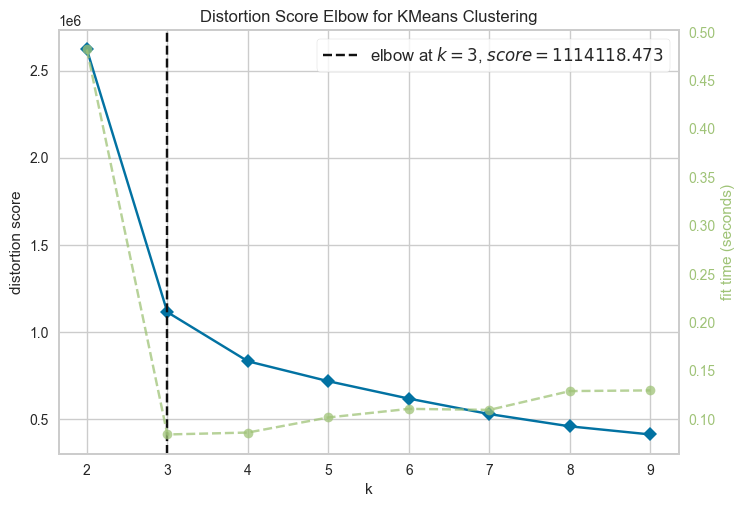

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=4), k=(2, 10))

In [11]:
'''
Verificar o número de classes por animal
'''
warnings.filterwarnings("ignore")
X = age_df.reset_index().groupby(['idAnimal'], as_index=False)[["peso"]].mean()
kelbow_visualizer(KMeans(random_state=4), X, k=(2,10))

In [15]:
'''
Realiza a classificação por animal
'''
warnings.filterwarnings("ignore")
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

cattle = age_df['idAnimal'].unique()
class_list = []
for i in range(0, len(y_kmeans)):
    length = age_df[age_df['idAnimal'] == cattle[i]].shape[0]
    idanimal_list = np.repeat(y_kmeans[i], length, axis=0)
    class_list.extend(idanimal_list.tolist())

age_df['classes'] = pd.DataFrame(class_list)
data = age_df.reset_index(drop=True)

In [16]:
data.head()

idAnimal  idBaia  idLote    peso        data  Idade  classes
0     25894     130     323  363.17  17/02/2022      0        1
1     25894     130     323  367.37  18/02/2022      1        1
2     25894     130     323  370.86  19/02/2022      2        1
3     25894     130     323  374.47  20/02/2022      3        1
4     25894     130     323  380.06  21/02/2022      4        1

In [12]:
def StratifiedGroupShuffleSplit(df_main: pd.DataFrame):
    '''
    Essa função estratifica o conjunto de dados por animal em dados de treinamento e dados de validação
    
    Os dados de entrada são:
    
    :df_main: Conjunto de dados
    
    :return: pd.DataFrame. 

    '''   
    df_main = df_main.reindex(np.random.permutation(df_main.index)) # shuffle dataset

    # create empty train, val and test datasets
    df_train = pd.DataFrame()
    df_val = pd.DataFrame()
    # df_test = pd.DataFrame()

    hparam_mse_wgt = 0.0 # must be between 0 and 1
    assert(0 <= hparam_mse_wgt <= 1)
    train_proportion = 0.7 # must be between 0 and 1
    assert(0 <= train_proportion <= 1)
    val_proportion = (1-train_proportion) #val_test_proportion = (1-train_proportion)

    subject_grouped_df_main = df_main.groupby(['idAnimal'], sort=False, as_index=False)#idLote
    category_grouped_df_main = df_main.groupby('classes').count()[['idAnimal']]/len(df_main)*100

    def calc_mse_loss(df):
        grouped_df = df.groupby('classes').count()[['idAnimal']]/len(df)*100
        df_temp = category_grouped_df_main.join(grouped_df, on = 'classes', how = 'left', lsuffix = '_main')
        df_temp.fillna(0, inplace=True)
        df_temp['diff'] = (df_temp['idAnimal_main'] - df_temp['idAnimal'])**2
        mse_loss = np.mean(df_temp['diff'])
        return mse_loss

    i = 0
    for _, group in subject_grouped_df_main:

        if (i < 2):#3
            if (i == 0):
                df_train = pd.concat([pd.DataFrame(group), df_train], ignore_index=True)
                i += 1
                continue
            else:#elif (i == 1)
                df_val = pd.concat([pd.DataFrame(group), df_val], ignore_index=True)
                i += 1
                continue
            # else:
            #     df_test = pd.concat([pd.DataFrame(group), df_test], ignore_index=True)
            #     i += 1
            #     continue

        mse_loss_diff_train = calc_mse_loss(df_train) - calc_mse_loss(pd.concat([pd.DataFrame(group), df_train]))
        mse_loss_diff_val = calc_mse_loss(df_val) - calc_mse_loss(pd.concat([pd.DataFrame(group), df_val]))
        # mse_loss_diff_test = calc_mse_loss(df_test) - calc_mse_loss(pd.concat([pd.DataFrame(group), df_test]))

        total_records = len(df_train) + len(df_val) #+ len(df_test)

        len_diff_train = (train_proportion - (len(df_train)/total_records))
        len_diff_val = (val_proportion - (len(df_val)/total_records)) #(val_test_proportion - (len(df_val)/total_records))
        # len_diff_test = (val_test_proportion - (len(df_test)/total_records)) 

        len_loss_diff_train = len_diff_train * abs(len_diff_train)
        len_loss_diff_val = len_diff_val * abs(len_diff_val)
        # len_loss_diff_test = len_diff_test * abs(len_diff_test)

        loss_train = (hparam_mse_wgt * mse_loss_diff_train) + ((1-hparam_mse_wgt) * len_loss_diff_train)
        loss_val = (hparam_mse_wgt * mse_loss_diff_val) + ((1-hparam_mse_wgt) * len_loss_diff_val)
        # loss_test = (hparam_mse_wgt * mse_loss_diff_test) + ((1-hparam_mse_wgt) * len_loss_diff_test)

        if (max(loss_train,loss_val) == loss_train):#(max(loss_train,loss_val,loss_test) == loss_train)
            df_train = pd.concat([pd.DataFrame(group), df_train])
        else:#elif (max(loss_train,loss_val,loss_test) == loss_val):
            df_val = pd.concat([pd.DataFrame(group), df_val])
        # else:
        #     df_test = pd.concat([pd.DataFrame(group), df_test])

        print ("Group " + str(i) + ". loss_train: " + str(loss_train) + " | " + "loss_val: " + str(loss_val) + " | ")# + "loss_test: " + str(loss_test) + " | ")
        i += 1

    return df_train, df_val


In [17]:
df_train, df_val = StratifiedGroupShuffleSplit(data)

Group 2. loss_train: 0.029583999999999975 | loss_val: -0.029583999999999975 | 
Group 3. loss_train: -0.00014872099940511625 | loss_val: 0.0001487209994051176 | 
Group 4. loss_train: 0.02098642455435238 | loss_val: -0.020986424554352363 | 
Group 5. loss_train: 0.0059937565036420355 | loss_val: -0.0059937565036420355 | 
Group 6. loss_train: 0.0007190786804406839 | loss_val: -0.0007190786804406839 | 
Group 7. loss_train: -0.00013977529180518838 | loss_val: 0.00013977529180518968 | 
Group 8. loss_train: 0.012948870392390012 | loss_val: -0.01294887039239 | 
Group 9. loss_train: 0.0069653456950647275 | loss_val: -0.006965345695064719 | 
Group 10. loss_train: 0.0015550621399165552 | loss_val: -0.0015550621399165509 | 
Group 11. loss_train: 2.9043708989206356e-05 | loss_val: -2.9043708989206953e-05 | 
Group 12. loss_train: -0.00025209301603805077 | loss_val: 0.0002520930160380525 | 
Group 13. loss_train: 0.0019702728029987434 | loss_val: -0.0019702728029987486 | 
Group 14. loss_train: 0.000338

In [18]:
df_train = df_train.sort_values(['idAnimal', 'idLote', 'Idade', 'peso'])
df_train = df_train.reset_index(drop=True)

# df_test = df_test.sort_values(['idAnimal', 'idLote', 'Idade', 'peso'])
# df_test = df_test.reset_index(drop=True)

df_val = df_val.sort_values(['idAnimal', 'idLote', 'Idade', 'peso'])
df_val = df_val.reset_index(drop=True)

In [115]:
os.chdir('D:\junior\PUC\TCC\Resultados')
df_train.to_csv('df_train.csv', index = False, sep = ';')
df_val.to_csv('df_val.csv', index = False, sep = ';')

In [11]:
path ='D:\junior\PUC\TCC\Resultados'
os.chdir(path)
df_train = pd.read_csv('df_train.csv',sep=';')

In [19]:

def normalize(df: pd.DataFrame):
    '''
    Essa função realiza a normalização dos dados
    
    Os dados de entrada são:
    
    :df: Os dados de entrada são os originais
    
    :return: pd.DataFrame. Os dados de saída são normalizados
    
    '''
    
    df = df.reset_index(drop=True)
    normalize_df = df[['Idade','peso']].to_numpy()
    scaler = MinMaxScaler()
    scaler.fit(normalize_df)
    normalize_array = scaler.transform(normalize_df)
    df = pd.concat([df, pd.DataFrame(normalize_array, columns=['idade_normalizado', 'peso_normalizado'])],axis=1)

    return df

In [20]:
train_df = normalize(df_train)
train_df.head()

idAnimal  idBaia  idLote    peso        data  Idade  classes  \
0     25823     130     323  354.68  24/03/2022      0        1   
1     25823     130     323  355.52  25/03/2022      1        1   
2     25823     130     323  356.47  26/03/2022      2        1   
3     25823     130     323  357.56  27/03/2022      3        1   
4     25823     130     323  358.73  28/03/2022      4        1   

   idade_normalizado  peso_normalizado  
0               0.03          0.151654  
1               0.04          0.154019  
2               0.05          0.156694  
3               0.06          0.159763  
4               0.07          0.163058

In [21]:
'''
Divide os dados de treinamento em dados de treino e dados de teste
'''
train_df = train_df.sort_values(by = "idAnimal", key = lambda x: np.argsort(train_df["idAnimal"]))
groups_series = train_df['idAnimal']
features_list = train_df.columns
X = train_df[features_list].values
y = train_df['peso'].values
groups_list = []  
group_kfold = GroupKFold(n_splits = 5)
group_kfold.get_n_splits(X, y, groups_series)
for train_index, test_index in group_kfold.split(X, y, groups_series):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train.tolist().append(y_train)
    X_test.tolist().append(y_test)
    groups_list.append([X_train, X_test])


In [22]:
'''
Organizar os dados
'''
train_list = []
test_list = []
cattle_train_list = []
cattle_test_list = []
for i in range(len(groups_list)):
    df_train = pd.DataFrame(groups_list[i][0])
    df_train.columns = ['idAnimal', 'idBaia', 'idLote', 'peso', 'data', 'Idade', 'classes', 'idade_normalizado', 'peso_normalizado']
    cattle_train_array = df_train['idAnimal'].unique()
    df_test = pd.DataFrame(groups_list[i][1])
    df_test.columns = ['idAnimal', 'idBaia', 'idLote', 'peso', 'data', 'Idade', 'classes', 'idade_normalizado', 'peso_normalizado']
    cattle_test_array = df_test['idAnimal'].unique()
    train_list.append(df_train)
    test_list.append(df_test)
    cattle_train_list.append(cattle_train_array)
    cattle_test_list.append(cattle_test_array)    

# Ajuste do modelo

## Treinamento de modelo

In [23]:
def globals_var(parameters_list: list, params_list: list):
    '''
    A função torna a variável local em variável global

    Os dados de entrada são:

    :parameters_list: Lista de valores da variável
    :params_list: Lista da variável selecionada

    '''

    dict_parameters = dict(zip(parameters_list, params_list))
    for name in parameters_list:
        if name in dict_parameters:
            values = dict_parameters[name]
            globals()[name] = values

In [25]:
def select_parameters(model: str):
    '''
    A função seleciona os valores dos hiperparâmetros 
    
    Os dados de entrada são:
    
    :model: Determina o tipo método para o ajuste de regressão: mlp, xgb, svm e lgb
    
    :return: list.
    
    '''
    
    if model == 'mlp':
        params_list = [(1, 2), # hidden_layer_sizes
                        (1e-5, 1e-01), # learning_rate_init
                        (1e-5, 1e-01)] # momentum

    if model == 'xgb':
        params_list = [(1e-5, 1e-01), # colsample_bynode  
                        (1e-5, 1e-01), # colsample_bytree
                        (1e-5, 1e-01), # learning_rate
                        (1, 10), # max_depth
                        (1, 10), # min_child_weight
                        (1, 10), # num_parallel_tree
                        (1, 100), # n_estimators
                        (1e-5, 1e-01)] # subsample

    if model == 'svm':
        params_list = [(1e-5, 1e-01), # C
                        (1, 10), # degree
                        (1e-5, 1e-01), # epsilon
                        (1e-5, 1e-01)] # gamma

    if model == 'ltb':
        params_list = [(1e-05, 1e-01), # colsample_bytree
                        (1e-05, 1e-01), # learning_rate
                        (1, 10), # max_depth
                        (1, 100), # min_child_samples
                        (1, 100), # n_estimators
                        (2, 128), # num_leaves
                        (1e-03, 0.9)] # subsample
            
    return params_list


In [26]:
def parameters(model: str):
    '''
    A função atribui os valores para os hiperparâmetros 
    
    Os dados de entrada são:
    
    :model: Determina o tipo método para o ajuste de regressão: mlp, xgb, svm e ltb
    
    :return: list. Retorna os hiperparâmetros
    
    '''
    
    if model == 'mlp':
        parameters_list = ['hidden_layer_sizes', 
                           'learning_rate_init',
                           'momentum']
        

    if model == 'xgb':
        parameters_list = ['colsample_bynode',
                           'colsample_bytree',
                           'learning_rate', 
                           'max_depth',
                           'min_child_weight', 
                           'num_parallel_tree',
                           'n_estimators',
                           'subsample']

    if model == 'svm':
        parameters_list = ['C', 
                           'degree', 
                           'epsilon',
                           'gamma']     

    if model == 'ltb':
        parameters_list = ['colsample_bytree',
                           'learning_rate', 
                           'max_depth',
                           'min_child_samples',
                           'n_estimators',
                           'num_leaves',
                           'subsample']     
         

    return parameters_list
            

In [27]:
def models(model: str, Xtrain: pd.DataFrame, ytrain: pd.Series):
    '''
    A função executa o modelo selecionado
    
    Os dados de entrada são:
    
    :model: Determina o tipo método para o ajuste de regressão: mlp, xgb, svm e ltb
    :Xtrain: Dados de treino
    :ytrain: Dados de treino
        
    :return: list. Retorna o modelo solicitado
    
    '''
    
    if model == 'mlp':
        mdl = MLPRegressor(activation = 'logistic',
                             hidden_layer_sizes = hidden_layer_sizes, 
                             learning_rate_init = learning_rate_init,
                             max_iter = 1000, 
                             momentum = momentum, 
                             solver = 'sgd', 
                             tol =  0.0001
                            )
        mdl.fit(Xtrain.values, ytrain.values)

    if model == 'xgb':
        mdl = xgb.XGBRegressor(booster = 'gbtree',
                                 colsample_bynode = colsample_bynode,
                                 colsample_bytree = colsample_bytree,
                                 learning_rate = learning_rate, 
                                 # gpu_id = '0',
                                 max_depth = max_depth, 
                                 min_child_weight = min_child_weight, 
                                 num_parallel_tree = num_parallel_tree,
                                 n_estimators = n_estimators,
                                 objective = 'reg:squarederror',
                                 subsample = subsample, 
                                 random_state = 0
                                 # tree_method = 'gpu_hist'
                                )
        mdl.fit(Xtrain.values, ytrain.values)

    if model == 'svm':
        mdl = SVR(C = C, 
                    degree = degree,
                    epsilon = epsilon,
                    gamma = gamma,
                    kernel = 'sigmoid', 
                    tol =  0.0001
                   )
        mdl.fit(Xtrain.values, ytrain.values)

    if model == 'ltb':
        mdl = ltb.LGBMRegressor(boosting_type = 'gbdt', 
                                  colsample_bytree = colsample_bytree, 
                                  learning_rate = learning_rate,
                                  max_depth = max_depth,
                                  min_child_samples = min_child_samples,
                                  n_estimators = n_estimators,
                                  num_leaves = num_leaves, 
                                  objective = 'regression', 
                                  subsample = subsample, 
                                  random_state = 0,
                                  subsample_freq = 1
                                 )
        mdl.fit(Xtrain.values, ytrain.values)
        
    
    return mdl

In [28]:
def optimize_hypermeters(Xtrain: pd.DataFrame, ytrain: pd.DataFrame, Xtest: pd.DataFrame, ytest: pd.DataFrame, model: str):
    '''
    A função realiza o treinamento dos hiperparâmetros dos modelos 
    
    Os dados de entrada são:
    
    :Xtrain: Dados de treino
    :ytrain: Dados de treino
    :Xtest: Dados de teste
    :ytest: Dados de teste
    :model: Determina o tipo método para o ajuste de regressão: mlp, xgb, svm e ltb
    
    :return: list. 
    
    '''
    
    def parameterization(params_list: list):

        parameters_list = parameters(model = model)

        globals_var(parameters_list, params_list)

        print(params_list, '\n')

        function = models(model, Xtrain, ytrain)

        predict = function.predict(Xtest.values.reshape(-1,1))

        return mean_squared_error(ytest, predict, squared = False)
    
    search_space = select_parameters(model)        

    result = gp_minimize(parameterization, search_space, random_state=1, verbose=1, n_calls=30, n_random_starts=10)

    return result.x

In [29]:
def fitted_model(train_list: list, test_list: list, model: str):
    '''
    A função realiza o ajuste de regressão dos dados por meio do modelo selecionado
    
    Os dados de entrada são:
    
    :train_list: Dados de treino
    :test_list: Dados de teste
    :model: Determina o tipo método para o ajuste de regressão: mlp, xgb, svm e ltb
    
    :return: list. Retorna o modelo solicitado
    
    '''
    
    model_list = []
    
    for i in range(len(train_list)):
        Xtrain = train_list[i][['idade_normalizado']]
        ytrain = train_list[i][['peso_normalizado']]

        if 'mlp' == model or 'svm' == model:
            Xtest = test_list[i][['idade_normalizado']]
            ytest = test_list[i][['peso_normalizado']]          
        if 'xgb' == model or 'ltb' == model:
            Xtest = test_list[i]['idade_normalizado'].astype(np.float64)
            ytest = test_list[i]['peso_normalizado'].astype(np.float64)

        mdl = optimize_hypermeters(Xtrain, ytrain, Xtest, ytest, model)

        parameters_list = parameters(model)
        params_list = mdl 

        globals_var(parameters_list, params_list)

        mdl_list = models(model, Xtrain, ytrain)
        
        
        mdl = mdl_list
        
        model_list.append(mdl)
                
    parameters_list = ['model_list']
    params_list = [model_list]
    
    globals_var(parameters_list, params_list)

    return model_list

In [47]:
model = 'mlp'
hyp_tuning = True
model_list = fitted_model(train_list,  test_list, model = model)

Iteration No: 1 started. Evaluating function at random point.
[2, 0.09325641036027252, 0.012821163548456383] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2021
Function value obtained: 0.1650
Current minimum: 0.1650
Iteration No: 2 started. Evaluating function at random point.
[2, 0.023616536805428093, 0.03966410692232967] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2070
Function value obtained: 0.1759
Current minimum: 0.1650
Iteration No: 3 started. Evaluating function at random point.
[1, 0.06697790621997998, 0.09355455168989515] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1430
Function value obtained: 0.1569
Current minimum: 0.1569
Iteration No: 4 started. Evaluating function at random point.
[2, 0.0313342189580582, 0.05245957047569143] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1810
Function value obtained: 0.1673
Current minimum: 0.1569
Iteration No: 5 started. Evaluating

## Predição

In [30]:
def predict(data_list: list, model_list: list, val: bool = True):
    '''
    A função realiza a predição dos dados
    
    Os dados de entrada são:
    
    :data_list: Dados de treino
    :model_list: Determina o tipo método para o ajuste de regressão: mlp, xgb, svm e ltb
    :val: Habilita a o conjunto de dados de validação do conjunto de dados 
    
    :return: list. 
    
    '''    
    multiple_list = [4, 9, 14, 19]
    pred_list = []
    if val == True:
        # length = 1
        length = len(model_list)
        temp_data_list = data_list
        temp_cattle_test_list = cattle_test_list     
    else:
        length = len(model_list) * 5
        temp_data_list = data_list * 5
        temp_cattle_test_list = cattle_test_list * 5
    count = 0
    temp = None
    for i in range(length):
        temp_df = temp_data_list[i]
        cattle_df = temp_df.reset_index(drop=True)
        cattle_series = cattle_df['idade_normalizado']
        xp_array = cattle_series.values.reshape(-1,1)       
        yp_array = model_list[count].predict(xp_array)        
        cattle_df['yp'] = pd.DataFrame(yp_array) 
        temp = pd.concat([temp, cattle_df])
        
        if val == False:
            if i in multiple_list:
                count += 1
            pred_list.append(temp)
        else:    
            pred_list.append(temp)            
        temp = None

    parameters_list = ['pred_list']
    params_list = [pred_list]

    globals_var(parameters_list, params_list)
    
    return pred_list



In [48]:
pred_list = predict(test_list, model_list, val = True)

In [31]:
def calc_rating_metrics(data_list: list):
    '''
    A função calcula a média em relação as métricas de avaliação mse e rmse
    
    Os dados de entrada são:
    
    :data_list: Resultados das métricas de avaliação
    
    :return: list.
    
    '''
    
    mse_mean_list = [ele1 for [ele1, ele2, ele3] in data_list]
    rmse_mean_list = [ele2 for [ele1, ele2, ele3] in data_list]

    return [np.mean(mse_mean_list), np.mean(rmse_mean_list)] 

In [32]:
def assessment_criteria(input_files: list, path: str, model: str, val: bool = False):
    '''
    A função calcula as métricas de mse, rmse e mape
    
    Os dados de entrada são:
    
    :data_list: Resultados das métricas de avaliação
    :path: Caminho do diretório para salvar o arquivo gerado 
    :model: Determina o tipo método para o ajuste de regressão: mlp, xgb, svm e ltb
    :val: Validação do conjunto de dados 
    
    :return: list.
    
    '''
    os.chdir(path)
    
    multiple_list = [4, 9, 14, 19, 24]
    temp_list = []
    rating_metrics_list = []
    mse_list = []
    rmse_list = []  
    temp_df = None
    for i in range(len(input_files)):
        test = input_files[i]['peso_normalizado']
        predict = input_files[i]['yp']
        mse = mean_squared_error(test, predict, squared = True)
        rmse = mean_squared_error(test, predict, squared = False)
        mape = mean_absolute_percentage_error(test, predict)
        temp_list.append([mse, rmse, mape]) 
        if val == False:    
            if i in multiple_list:
                calc_metrics_list = calc_rating_metrics(temp_list)
                rating_metrics_list.append(calc_metrics_list)
                # temp_list = []
        else:
            calc_metrics_list = calc_rating_metrics(temp_list)
            rating_metrics_list.append(calc_metrics_list)
        temp_list = []           
            
    rating_metrics_df = pd.DataFrame(rating_metrics_list)
    rating_metrics_df.columns = ['MSE.avg', 'RMSE.avg']
    save = model.upper() + '.csv'#'_val_' + '.csv'
    rating_metrics_df.to_csv(save, index = False, sep = ';')     

    parameters_list = ['rating_metrics_df']
    params_list = [rating_metrics_df]

    globals_var(parameters_list, params_list)
    
    return rating_metrics_df
    

In [ ]:
rating_metrics_df = assessment_criteria(pred_list, path, model, val = True) 

## Executar as funções

In [33]:
model_lst = ['svm', 'mlp', 'xgb', 'ltb'] # Modelos de ajuste
path = 'D:\junior\PUC\TCC\LIXO'# Caminho para salvar o arquivo pdf

In [34]:
mse_list = []
mse_lst = []
    
for model in model_lst:
    print('###############################################################################################################')
    print(model.upper())  

    # Etapa 1
    fitted_model(train_list,  test_list, model = model)
    # Etapa 2
    predict(test_list, model_list, val = False)
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(model.upper() + '_train_' + ".xlsx", engine="xlsxwriter")
    for i in range(len(pred_list)):
        temp_df = pred_list[i]
        temp_df.to_excel(writer, index=False, sheet_name='Planilha' + str(i+1))
    # Close the Pandas Excel writer and output the Excel file.
    writer.close() 
    # Etapa 3
    assessment_criteria(pred_list, path, model, val = False)
    # Etapa 4
    # Etapa para selecionar o melhor modelo
    mse_lst.append(rating_metrics_df['MSE.avg'].groupby(rating_metrics_df.index//len(cattle_train_list)).mean())
    mse_list.append(mse_lst)
    mse_lst = []

###############################################################################################################
SVM
Iteration No: 1 started. Evaluating function at random point.
[0.09971850924577749, 9, 0.012821163548456383, 0.09990406112726126] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.4635
Function value obtained: 0.1415
Current minimum: 0.1415
Iteration No: 2 started. Evaluating function at random point.
[0.023616536805428093, 5, 0.038797195008789136, 0.06697790621997998] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 13.2211
Function value obtained: 0.1424
Current minimum: 0.1415
Iteration No: 3 started. Evaluating function at random point.
[0.09355455168989515, 9, 0.0313342189580582, 0.05245957047569143] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.9512
Function value obtained: 0.1421
Current minimum: 0.1415
Iteration No: 4 started. Evaluating function at random point.
[0.044350854849017886, 3, 0.0534

In [ ]:
for i in range(len(pred_list)):
    temp_df = pred_list[i][[ 'Idade', 'peso_normalizado', 'yp']]
    temp_df.columns = ['Idade', 'Peso', 'Peso predito']
    sns.set(style="darkgrid", font_scale=1.2)
    ax=sns.lineplot(x='Idade', y='value', hue='variable', 
                data=pd.melt(temp_df, ['Idade']),
                palette=['red', 'blue'])
    ax.set(xlabel='Idade (Dias)', ylabel='Peso normalizado')
    ax.legend(loc='upper left', title='')
    # plt.show()
    plt.savefig('mlp_train_0' + str(i) + '_' + '.jpeg')
    plt.close()

# Execução com dados de validação

## Selecionar o melhor modelo

In [35]:
mse_lst=[]
for i in range(len(model_lst)):
    temp = [mse_list[i][0].values[0]]
    mse_lst.append(temp)
    

In [36]:
mse_min = min(mse_lst)
pos_index = mse_lst.index(mse_min)
model = model_lst[pos_index] 
best_model = [model, mse_min[0]]
best_model

['ltb', 0.019700163189927317]

## Validar o modelo

In [37]:
training_data_list = []
val_data_list = []
cattle_train_list = []
cattle_test_list = []


val_df = normalize(df_val)
train_df = train_df.sort_values(by = "idAnimal", key = lambda x: np.argsort(index_natsorted(train_df["idAnimal"])))
cattle_train_array = train_df['idAnimal'].unique()
cattle_test_array = val_df['idAnimal'].unique()

training_data_list.append(train_df)
val_data_list.append(val_df)
cattle_train_list.append(cattle_train_array)
cattle_test_list.append(cattle_test_array)
    


## Definir os parâmetros de entrada

In [38]:
path = 'D:\junior\PUC\TCC\LIXO'  # Caminho para salvar o arquivo pdf

In [39]:
mse_list = []
model = best_model[0]
# Etapa 1
fitted_model(training_data_list,  val_data_list, model = model)
# Etapa 2
predict(val_data_list, model_list, val = True)
writer = pd.ExcelWriter(model.upper() + '_val_' + ".xlsx", engine="xlsxwriter")
for i in range(len(pred_list)):
    temp_df = pred_list[i]
    temp_df.to_excel(writer, index=False, sheet_name='Planilha' + str(i+1))
# Close the Pandas Excel writer and output the Excel file.
writer.close() 
# Etapa 3
assessment_criteria(pred_list, path, model, val = True)
mse_list.append(rating_metrics_df['MSE.avg'].groupby(rating_metrics_df.index//len(cattle_train_list)).mean())

Iteration No: 1 started. Evaluating function at random point.
[0.09971850924577749, 0.09325641036027252, 2, 100, 24, 52, 0.34973175630464476] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0291
Function value obtained: 0.1224
Current minimum: 0.1224
Iteration No: 2 started. Evaluating function at random point.
[0.06697790621997998, 0.09355455168989515, 9, 32, 53, 58, 0.20738991514311322] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0830
Function value obtained: 0.1227
Current minimum: 0.1224
Iteration No: 3 started. Evaluating function at random point.
[0.05344604675561225, 0.09139706283767753, 5, 44, 94, 100, 0.6446574938555596] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0752
Function value obtained: 0.1228
Current minimum: 0.1224
Iteration No: 4 started. Evaluating function at random point.
[0.08027772281869715, 0.009289152855987387, 6, 87, 83, 107, 0.24647192682085595] 

Iteration No: 4 ended. Evaluatio

In [40]:
pred_list = []
data = pd.read_excel('LTB_val_.xlsx', sheet_name = 'Planilha' + str(0+1))
pred_list.append(data)

In [46]:
temp_df = pred_list[0][[ 'Idade', 'peso_normalizado', 'yp']]
temp_df.columns = ['Idade', 'Peso', 'Peso predito']
sns.set(style="darkgrid", font_scale=1.2)
ax=sns.lineplot(x='Idade', y='value', hue='variable', 
            data=pd.melt(temp_df, ['Idade']),
            palette=['red', 'blue'])
ax.set(xlabel='Idade (Dias)', ylabel='Peso normalizado')
ax.legend(loc='upper left', title='')
# plt.show()
plt.savefig('ltb_val' + '.jpeg')
plt.close()